# TF-IDF and Fake News Detection
*by Lottie Andrews*

In [1]:
#Python libraries
import string
import math

import pandas as pd # Data formatting
import numpy as np # Numerical analysis

#Data preprocessing
import nltk
from nltk.corpus import stopwords as sw
from nltk.stem.snowball import SnowballStemmer

#Feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Model creation
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

#Visualizations
from sklearn.metrics import confusion_matrix
from sklearn.metrics._plot import confusion_matrix as cm
import matplotlib.pyplot as plt

The widespread use of social media has, especially recently, put the threat of misinformation on many people’s radar. However, as today’s highly polarized political climate and the pay-per-click economy of the internet nudge many mainstream news outlets towards sensationalism, fake news is becoming harder and harder to distinguish from the truth. Furthermore, algorithms designed to customize user content based on user interest perpetuate the spread of whatever content draws the user’s attention, often without regard for that content’s credibility. With the weaponization of fake news becoming a hot topic in recent years, here is a higher need than ever to detect, prevent, and counteract this type of algorithmic bias.

Luckily, the solution to this problem may also lie within the scope of machine learning. [Many different types](https://www.albany.edu/~sp191221/publications/Fake_Media_Rich_News_Detection_A_Survey.pdf) of machine learning methods have been employed to combat the problem of fake news detection, and many popular social media platforms, such as [Facebook and Instagram](https://www.impactplus.com/blog/facebook-and-instagram-starting-to-identify-and-label-fake-news-before-it-goes-viral), have employed ML-based fake news detectors in an attempt to curb the spread of misinformation. 

In machine learning, fake news detection is most commonly addressed as a text classification problem. **Text classification** is one of the most common types of supervised machine learning problems in the field of **Natural Language Processing (NLP).** In this notebook we will explore how a dataset of real and fake news articles can be transformed into numerical data features using a method called the Bag-of-Words model, as well as a derived method called TF-IDF vectorization. We will then see how this numerical data can be passed to a classifier in order to detect fake news articles within the dataset.

This notebook contains three main sections:
1. An illustrated explanation of the TF-IDF model and its baseline, the Bag-of-Words approach
2. An introduction to the dataset and data cleaning
3. Feature extraction on the dataset using the TF-IDF and Bag-of-Words models, and a comparison of classifier accuracy between the two transformed datasets using random forests

## 1. Bag-of-Words & TF-IDF

Because machine learning algorithms are designed to handle numerical data, the first step to any text classification problem is to create a numerical representation of text data. This process is known as **feature extraction**. In NLP, the baseline approach for feature extraction is known as the **Bag-of-Words model**. 

### Bag of Words
The Bag-of-Words model takes a *corpus* of documents, and begins by tokenizing each document into separate words or characters. As in Jason Brownlee's [Bag-of-Words tutorial](https://machinelearningmastery.com/gentle-introduction-bag-words-model/), we will use the first four lines of 
Charles Dickens' "[A Tale of Two Cities](https://www.gutenberg.org/files/98/98-h/98-h.htm)" as our example "documents." The last two lines have been modified slightly and joined into one to create a variance in document length.

In [2]:
doc0 = "it was the best of times"
doc1 = "it was the worst of times"
doc2 = "it was the age of wisdom and the age of foolishness"

corpus_df = pd.DataFrame([[doc0.split()], [doc1.split()], [doc2.split()]])
corpus_df

,0
0,"[it, was, the, best, of, times]"
1,"[it, was, the, worst, of, times]"
2,"[it, was, the, age, of, wisdom, and, the, age,..."


It then **tokenizes** the data by separating each line in the corpus into individual words (or *tokens*), creates a *vocabulary* of every unique token that appears in the corpus, and creates a numerical vector representing the presence of each token in every document. This vectorization process is also called **scoring**. Scoring can be done using one of several different methods; the tutorial linked above uses a binary method of scoring, using 1 to represent the presence of a word in a document and 0 to represent its absence. The example below, however, creates a vector representing the number of times every word in the vocabulary appears in each document.

In [3]:
def bag_of_words(corpus):
    data = corpus.copy()
    vocab = np.unique(np.concatenate(corpus_df.iloc[:,0].values))
    counts = pd.DataFrame(0, index=data.iloc[:,0].index.values, columns = vocab)
    for row in data.transpose():
        for word in data.iloc[:,0][row]:
            counts[word][row] += 1
    return counts

In [4]:
bow = bag_of_words(corpus_df)
bow

,age,and,best,foolishness,it,of,the,times,was,wisdom,worst
0,0,0,1,0,1,1,1,1,1,0,0
1,0,0,0,0,1,1,1,1,1,0,1
2,2,1,0,1,1,2,2,0,1,1,0


There are several limitations to the bag of words model:
1. **Sparsity:** Large datasets will result in a large vocabulary size, which in turn yield a sparse vector representation of the data. Sparse vector representations can hinder both speed and accuracy during classification due to their size and the level of noise they contain. There are several techniques which can be used during data preprocessing to help manage vocabulary size, several of which will be discussed in Part 2 of this notebook.
2. **Context:** Word order is ignored, meaning that no information can be gained from word context or document structure. Therefore, while Bag of Words and related models such as TF-IDF can be useful for text classification, they are not well-suited to other NLP tasks which rely on contextualization, such as [question answering](https://towardsdatascience.com/nlp-building-a-question-answering-model-ed0529a68c54), [text summarization](https://medium.com/luisfredgs/automatic-text-summarization-with-machine-learning-an-overview-68ded5717a25), and [statistical language modeling](https://machinelearningmastery.com/statistical-language-modeling-and-neural-language-models/).
3. **Word Importance:** Words that occur commonly throughout the dataset but may not contain much useful information, such as conjunctions, pronouns, and articles, are weighted more heavily than words that are less common, but may be more informative to the model.

The TF-IDF model addresses the third issue discussed above by scaling the values obtained by the Bag-of-Words model according to the length of each document and how often each word appears in the corpus as a whole.

### TF-IDF

The term **TF-IDF** is an acronym for the formula the model uses to score data:

$$\text{Term Frequency (TF) }\times \text{ Inverse Document Frequency (IDF)}$$

While [several variations](https://nlp.stanford.edu/IR-book/pdf/06vect.pdf) of the TF-IDF formula exist, the weight of a term $t$ in document $d$ is commonly defined as:

$$w_{t,d} = \mathit{tf}_{t,d}\times log\frac{N}{\mathit{df}_t + 1}$$

where $\mathit{tf}$ is the number of times $t$ appears in $d$ (the value calculated by the standard Bag-of-Words model), $N$ is the total number of documents in the corpus, and $\mathit{df}$ is the number of documents containing $t$. The addition of 1 in the denominator of the $\mathit{idf}$ term prevents division by 0.

The code below demonstrates how the TF-IDF changes the feature weights created by the Bag-of-Words model.

In [5]:
#TF is calculated by bag_of_words() above.

def calc_IDF(bag, calc_DF = False):
    N = len(bag) #Number of documents in corpus
    
    #Dataframe storing df values (number of documents containing each term t)
    rtn = pd.DataFrame([(bag!=0).sum()], index = [0], columns = bag.keys())
    
    #Calculate log(N/df + 1) for all df values in dataframe
    if not(calc_DF):
        rtn = pd.DataFrame(rtn.apply(lambda df : math.log(N/df + 1))).transpose()
    
    #Return dataframe of df values if calc_DF == True
    #Return dataframe of idf values if calc_DF == False
    return rtn

def calc_TF_IDF(corpus):
    tf= bag_of_words(corpus)  #Calculate tfs
    idf = np.array(calc_IDF(tf)) #Calculate idfs
    
    #Return dataframe of tf-idf values
    return pd.DataFrame(np.array(tf) * idf, columns = tf.keys())

In [6]:
tfidf = calc_TF_IDF(corpus_df)
tfidf

,age,and,best,foolishness,it,of,the,times,was,wisdom,worst
0,0.000000,0.000000,1.386294,0.000000,0.693147,0.693147,0.693147,0.916291,0.693147,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.693147,0.693147,0.693147,0.916291,0.693147,0.000000,1.386294
2,2.772589,1.386294,0.000000,1.386294,0.693147,1.386294,1.386294,0.000000,0.693147,1.386294,0.000000


It is worth noting that the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) implementation of the TF-IDF vectorizer, which we will use in Part 3 of this notebook for the sake of speed, uses a formula that [varies slightly](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) from the textbook TF-IDF equation provided above. However, both implementations still create the same patterns in the resulting weight vectors, which all variations of the TF-IDF model aim to generate:
1. $w$ is highest when a term occurs many times within a small handful of documents,
2. $w$ is lower when a term occurs only a few times in a document or is present in a large number of documents, and
3. $w$ is lowest when a term is present in every document in the corpus.

## 2. Preparing the Dataset

The dataset we will use in this notebook, which was compiled by data scientist George McIntyre, can be downloaded [here](https://drive.google.com/file/d/1lpnJb0RoZSAQi2T4OlotTKh-7raLodnR/view?usp=sharing). It contains 3,171 real news articles and 3,164 fake news articles.

In Part 3 we will perform both Bag-of-Words and TF-IDF vectorization on the dataset and compare how accurately a Random Forest Classifier performs on each transformation of our data.

Before this can be done, however, we must perform **preprocessing** on our dataset in order to remove potentially noisy features and prepare it for encoding.

***NOTE:*** *You must download the dataset from the link above and move it to the same directory as this notebook in order for the rest of the notebook to run.*

In [7]:
news = pd.read_csv('news.csv')
news.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [8]:
news.isnull().values.any()

False

Since our dataset contains no null values, we don't have to worry about handling any missing data. Our first step, therefore, is to format our features.

The numerical IDs of each article are of no use to us, so we can remove column *'0'* from the dataset. We can also join the *'title'* and *'text'* columns so that all of our text data is contained in a single column.

In [9]:
#Remove nonsensical numerical labels
news.drop(news.columns[0], axis = 1, inplace = True)

#Join title and text columns together
news['article'] = news['title'] + ' ' + news['text']

#Remove individual columns
news.drop(['title', 'text'], axis = 1, inplace = True)

news.head()

,label,article
0,FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...
1,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...
2,REAL,Kerry to go to Paris in gesture of sympathy U....
3,FAKE,Bernie supporters on Twitter erupt in anger ag...
4,REAL,The Battle of New York: Why This Primary Matte...


Next, we want to create numerical labels for our data. We will use 0 to denote a fake news article and 1 to denote a real one.

In [10]:
#Rename labels (REAL = 1, FAKE = 0)
news['label'] = news['label'].replace(['FAKE','REAL'],[0,1])

news.head()

,label,article
0,0,You Can Smell Hillary’s Fear Daniel Greenfield...
1,0,Watch The Exact Moment Paul Ryan Committed Pol...
2,1,Kerry to go to Paris in gesture of sympathy U....
3,0,Bernie supporters on Twitter erupt in anger ag...
4,1,The Battle of New York: Why This Primary Matte...


Now that our data is properly formatted, we can complete the preprocessing step.

### Preprocessing Techniques

In Part 1 of this notebook, we discussed the importance of managing vocabulary size in order to reduce the level of noise in our dataset and decrease the runtime of our classifier. We will employ several preprocessing techniques on our data in order to remove irrelevant information and simplify our features, some of which are relatively straightforward and some of which we will discuss in slightly more depth:
- Removing punctuation
- Converting all characters to lowercase
- Tokenization
- Removing stopwords
- Removing words with length <= 2
- Stemming*

### Stopwords
**Stopwords** are words that are highly common to a given language ("the", "and", "of", "is", etc). These words are likely to be present multiple times in virtually every document in the corpus without providing much meaning to the reader nor information to our classifier. Therefore, we can consider them to be noise features and remove them from our dataset. When we apply our preprocessing to the dataset we will remove the following stopwords using the list provided by NLTK:

In [11]:
print(sw.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Stemming*
**Stemming** is a process by which words are reduced to their base forms. The [aim of this process](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) is to group together similar words in a document which have similar meanings ("run", "runs", and "running," for example) into a single feature, thus reducing vocabulary size. Stemming accomplishes this by chopping off the suffixes of words. Below we can see how the previous sentence looks when stemming is applied using NLTK's [Snowball Stemmer](https://www.nltk.org/_modules/nltk/stem/snowball.html):

In [12]:
sentence = "Stemming accomplishes this by chopping off the suffixes of words"
ss = SnowballStemmer('english')
stems = [ss.stem(word) for word in sentence.split()]
stems

['stem',
 'accomplish',
 'this',
 'by',
 'chop',
 'off',
 'the',
 'suffix',
 'of',
 'word']

**\***It is important to note that stemming has actually been found to [decrease accuracy](https://mimno.infosci.cornell.edu/papers/schofield_tacl_2016.pdf) in some classification problems, implying that stemming can result in the loss of information that may be relevant to the model. This was found to be the case for our dataset during the process of fine-tuning the final model. Due to this observation and the fact that stemming significantly increases the runtime of the preprocessor, stemming will by default ***not*** be applied to the dataset. However, preprocessor( ) contains an optional parameter *'apply_stemming'* so that the code can be modified to show the effects of applying stemming to the data.

### Preprocessing the Data
We can now apply preprocessing to our dataset:

In [13]:
def preprocessor(text, apply_stemming = False):   
    #Remove punctuation and numbers
    text = text.translate(str.maketrans('','', string.punctuation + "\\“”"))
    text = text.replace("’", "'")
    text = text.replace("‘", "'")
    
    #Replace apostrophes with spaces, thus separating contractions into two and stemming posessive nouns
    text = text.replace("'", " ")
    
    #Tokenize, change all tokens to lowercase, remove stopwords & words of length <= 2
    #Apply stemming to each token if apply_stemming == True
    stopwords = sw.words('english')
    if(apply_stemming):
        ss = SnowballStemmer('english')
        rtn = [ss.stem(word.lower()) for word in text.split() if (word.lower() not in stopwords and len(word) > 2)]
    else:        
        rtn = [word.lower() for word in text.split() if (word.lower() not in stopwords and len(word) > 2)]
    
    return rtn;

In [14]:
news['clean'] = news['article'].apply(preprocessor)

In [15]:
news.head()

,label,article,clean
0,0,You Can Smell Hillary’s Fear Daniel Greenfield...,"[smell, hillary, fear, daniel, greenfield, shi..."
1,0,Watch The Exact Moment Paul Ryan Committed Pol...,"[watch, exact, moment, paul, ryan, committed, ..."
2,1,Kerry to go to Paris in gesture of sympathy U....,"[kerry, paris, gesture, sympathy, secretary, s..."
3,0,Bernie supporters on Twitter erupt in anger ag...,"[bernie, supporters, twitter, erupt, anger, dn..."
4,1,The Battle of New York: Why This Primary Matte...,"[battle, new, york, primary, matters, primary,..."


Since [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) both automatically tokenize whatever data is passed in, we need to rejoin each list of tokens in our cleaned dataset:

In [16]:
news['clean'] = news['clean'].str.join(' ')
news.head()

,label,article,clean
0,0,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary fear daniel greenfield shillman ...
1,0,Watch The Exact Moment Paul Ryan Committed Pol...,watch exact moment paul ryan committed politic...
2,1,Kerry to go to Paris in gesture of sympathy U....,kerry paris gesture sympathy secretary state j...
3,0,Bernie supporters on Twitter erupt in anger ag...,bernie supporters twitter erupt anger dnc trie...
4,1,The Battle of New York: Why This Primary Matte...,battle new york primary matters primary day ne...


## 3. Feature Extraction & Classification

Now that our dataset has been preprocessed, we can perform feature extraction in order to create two different numerical representations of the data: one using the Bag-of-Words model and one using TF-IDF.

In [17]:
X = np.array(news['clean'])
y = np.array(news['label'])

In [18]:
orig_vocab = np.unique(np.concatenate(np.array(news['article'].str.split())))

#Number of unique features in the dataset prior to preprocessing
len(orig_vocab)

219529

In [19]:
bow = CountVectorizer()
X_bow = bow.fit_transform(X)

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

len(X_bow.A[0]), len(X_tfidf.A[0])

(84174, 84174)

As the code above shows, the size of our vocabulary shrank significantly during preprocessing. Using the techniques above helped us to maximize the amount of noise removed from the dataset, while minimizing the number of informative features lost.

Another useful feature of CountVectorizer and TfidfVectorizer is that they allow us to set a maximum number of features to select from the transformed data ordered by term frequency across the corpus. This allows us to narrow our features down even further:

In [20]:
bow = CountVectorizer(max_features = 5000)
X_bow = bow.fit_transform(X)

tfidf = TfidfVectorizer(max_features = 5000)
X_tfidf = tfidf.fit_transform(X)

len(X_bow.A[0]), len(X_tfidf.A[0])

(5000, 5000)

We will now split each of our transformations using [Stratified K-Fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) and classify our data using the [random forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) with [cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html).

In [21]:
def classify(X, y, plot_conf_matrix = True):
    classifier = RandomForestClassifier(n_jobs = -1, random_state=0)
    cv = StratifiedKFold(random_state=0, shuffle=True)
    
    # Classify data and calculate accuracy
    y_pred = cross_val_predict(classifier, X, y, cv=cv)
    
    #Plot confusion matrix and report accuracy if plot_conf_matrix == True
    if(plot_conf_matrix):
        print("Mean Accuracy: ", np.mean(y==y_pred))
        matrix = cm.ConfusionMatrixDisplay(confusion_matrix(y, y_pred), display_labels = ['FAKE','REAL'])
        matrix.plot(include_values=True,
          cmap='inferno');
    else:
        #Return accuracy if plot_conf_matrix == False
        return np.mean(y==y_pred)

#### Performance of Random Forest Classifier Using Bag-of-Words

Mean Accuracy:  0.9112865035516969


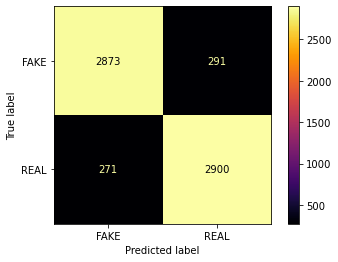

In [22]:
classify(X_bow,y)

#### Performance of Random Forest Classifier Using TF-IDF

Mean Accuracy:  0.9164956590370955


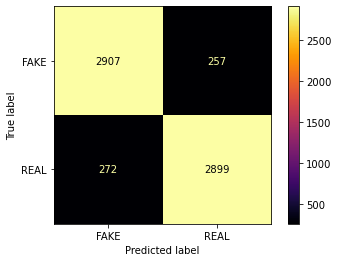

In [23]:
classify(X_tfidf,y)

As we can see from the above confusion matrices, using the TF-IDF model for feature selection improved the accuracy of the classifier by a small margin.

But how many useful features did we remove from our dataset? Would our classifier have performed better with all 62,653 of our remaining features still present? Is there a point where the Bag-of-Words model actually outperforms TF-IDF? We can observe the answers to these questions by looping over a list of different values for *max_features* and plotting the resulting accuracies:

In [24]:
def plot_max_feature_accs(X, y):
    feature_nums = [500, 1000, 2500, 5000, 10000, 25000, 62653]
    bow_acc = np.zeros(len(feature_nums))
    tfidf_acc = np.zeros(len(feature_nums))

    for i in range(len(feature_nums)):
        bow = CountVectorizer(max_features = feature_nums[i])
        X_bow = bow.fit_transform(X)

        tfidf = TfidfVectorizer(max_features = feature_nums[i])
        X_tfidf = tfidf.fit_transform(X)
        
        bow_acc[i] = classify(X_bow, y, plot_conf_matrix = False)
        tfidf_acc[i] = classify(X_tfidf, y, plot_conf_matrix = False)

    plt.scatter(feature_nums, bow_acc, c='#ff6600',s=75, label="Bag-of-Words")
    plt.scatter(feature_nums, tfidf_acc, c='#770087',s=75, label="TF-IDF")
    plt.xscale("log")
    plt.xlabel("Number of Features")
    plt.ylabel("Mean Accuracy")
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

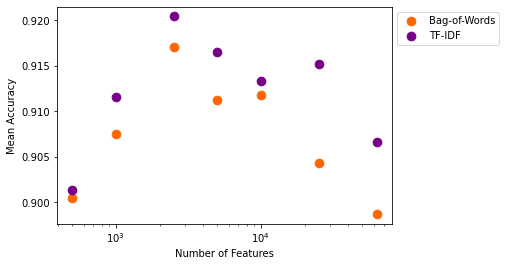

In [25]:
plot_max_feature_accs(X, y)

The above scatter plot shows that the TF-IDF model for feature selection consistently outperforms the Bag-of-Words model regardless of the number of features passed to the classifier. It also seems that 5000 features was a relatively strong selection for the optimum number of features to pass to the classifier for both the TF-IDF and Bag-of-Words models.

It may also be concluded from the plot above that the optimum ratio of noise features removed from the dataset to informative features included occurs when the number of features passed to the classifier falls somewhere around 5000 features.

## Summary
In this notebook, we were introduced to the topics of feature extraction in text data, the Bag-of-Words and TF-IDF methods for feature extraction, and several techniques for performing data preprocessing for the purpose of text classification.

This notebook provided just an introduction to some of the many techniques used in text classification, and an even more brief look into the topic of fake news detection. Fake news is a topic which has endless applications in machine learning, both in its perpetuation and its eradication. 